# Imports

In [1]:
# Import package EquiPy (pip install from GitHub to have the latest version)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import equipy
np.random.seed(2024)

# Data

In [3]:
# Import dataset
df = pd.read_csv('data/data_mortality.csv')
print("Number of rows in the dataset: ", df.shape[0])
print("Number of columns in the dataset: ", df.shape[1])

Number of rows in the dataset:  547878
Number of columns in the dataset:  16


In [4]:
df.head(3)

,d,exposure,duration,Age,Sex,reg_nod_pos,Mitoticrate,Laterality,Ulceration,Site_rec_WHO08,Origin,Mar_stat,Extent,Surg_primsite,Tumor,Positive_Node
0,0,1.0,0,65,Male,0,0,Right origin,No ulceration,Pleura,White,Missing,Localized,Surgery,T1,N0
1,0,1.0,1,66,Male,0,0,Right origin,No ulceration,Pleura,White,Missing,Localized,Surgery,T1,N0
2,1,1.0,2,67,Male,0,0,Right origin,No ulceration,Pleura,White,Missing,Localized,Surgery,T1,N0


# Logistic regression

In [5]:
# Perform one-hot encoding for categorical variables to apply Random Forest
df_encoded = pd.get_dummies(df, columns=['Sex', 'Laterality', 'Ulceration',
                                         'Site_rec_WHO08', 'Origin', 'Mar_stat',
                                         'Extent', 'Surg_primsite', 'Tumor',
                                         'Positive_Node'], drop_first=True)

## Split data into train, calibration and test sets

In [6]:
# Split the data into train, calibration and test sets
# During mitigation, we will need the calibration set and we won't touch the train set
X = df_encoded.drop("d", axis=1)
y = df_encoded["d"]

# Splitting into two datasets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split the temporary set into calibration and test sets
X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
# Sample weights for train set (exposure during the year)
weights_train = np.array(X_train['exposure'])

In [8]:
# Create and train the logistic regression model
X_train = X_train.drop("exposure", axis=1)
X_calib = X_calib.drop("exposure", axis=1)
X_test = X_test.drop("exposure", axis=1)

LR = LogisticRegression(max_iter=200)
LR.fit(X_train, y_train, sample_weight=weights_train)

# Get predicted scores of calibration and test sets
scores_train = LR.predict_proba(X_train)[:, 1]
scores_calib = LR.predict_proba(X_calib)[:, 1]
scores_test = LR.predict_proba(X_test)[:, 1]


In [9]:
df_train = df.iloc[X_train.index,:]

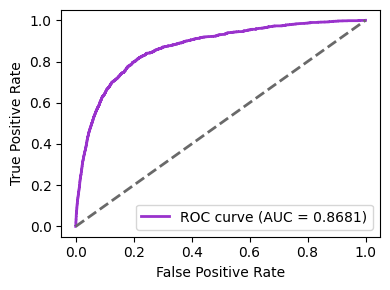

In [10]:
# ROC curve on calibration and test sets

# Compute ROC curve and area under the curve (AUC)
y_true = np.concatenate((y_calib, y_test))
scores = np.concatenate((scores_calib, scores_test))
fpr, tpr, thresholds = roc_curve(y_true, scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc), 
         color='darkorchid')
plt.plot([0, 1], [0, 1], color='dimgrey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC Curve on test set')
plt.legend(loc='lower right')
plt.tight_layout()

# Display the plot
plt.show()


In [11]:
# Define a range of thresholds to evaluate
thresholds = np.arange(0.1, 1.0, 0.001)
# Initialize variables to store optimal values
best_threshold = 0
best_f1 = 0

# Iterate through thresholds and calculate F1 score
for threshold in thresholds:
    y_true = np.concatenate((y_calib, y_test))
    scores = np.concatenate((scores_calib, scores_test))
    predicted_labels = (scores_train > threshold).astype(int)
    f1 = f1_score(y_train, predicted_labels)
    
    # Update optimal values if F1 score is higher
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

In [12]:
# Print the optimal threshold and F1 score
print(f"Optimal Threshold: {best_threshold:.4f}")
# Print the optimal threshold and F1 score
print(f"Optimal F1 Score: {best_f1:.4f}")

Optimal Threshold: 0.1010
Optimal F1 Score: 0.1345


## Predicted classes

In [13]:
# Define classes on predicted scores for each dataset
threshold = best_threshold
y_pred_train = (scores_train > threshold).astype(int)
y_pred_calib = (scores_calib > threshold).astype(int)
y_pred_test = (scores_test > threshold).astype(int)

## Model performance

In [14]:
# Evaluate the classifier : no overfitting
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_calib = accuracy_score(y_calib, y_pred_calib)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on train dataset: {accuracy_train:.4f}")
print(f"Accuracy on calibration dataset: {accuracy_calib:.4f}")
print(f"Accuracy on test dataset: {accuracy_test:.4f}")

Accuracy on train dataset: 0.9857
Accuracy on calibration dataset: 0.9858
Accuracy on test dataset: 0.9861


In [15]:
# Calculate confusion matrix on test set
conf_matrix = confusion_matrix(y_test, y_pred_test)
# Calculate precision
precision = precision_score(y_test, y_pred_test)
# Calculate recall
recall = recall_score(y_test, y_pred_test)
# Calculate f1-score
f1 = f1_score(y_test, y_pred_test)

#print("Confusion matrix on test dataset:\n", conf_matrix)
print(f"Precision on test dataset: {precision:.4f}")
print(f"Recall on test dataset: {recall:.4f}")
print(f"F1-score on test dataset: {f1:.4f}")

Precision on test dataset: 0.1259
Recall on test dataset: 0.1489
F1-score on test dataset: 0.1364


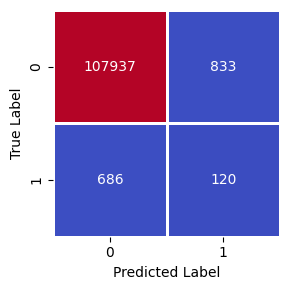

In [16]:
# Confusion matrix
LABELS = ['0', '1']

def show_confusion_matrix(observations, predictions, title=None):
    matrix = confusion_matrix(observations, predictions)

    plt.figure(figsize=(3, 3))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d',
                cbar=False)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

show_confusion_matrix(y_test, y_pred_test)

# Application of EquiPy

In [17]:
from equipy.metrics import performance, unfairness
from equipy.fairness import MultiWasserstein
from equipy.graphs import fair_arrow_plot, fair_multiple_arrow_plot, fair_density_plot, fair_waterfall_plot

## Calibration and test sets

In [18]:
# Test and calibration datasets without one-hot encoding
df_calib = df.loc[X_calib.index]
df_test = df.loc[X_test.index]

In [19]:
# Rename datasets to facilitate the EquiPy package application
# Creation of the objects useful for the package
x_ssa_calib = df_calib[['Origin','Sex']]
x_ssa_test = df_test[['Origin','Sex']]
# True outcome values (0/1)
y_true_calib = np.array(y_calib)
y_true_test = np.array(y_test)

print("The two sensitive attributes are: ", x_ssa_calib.columns)

The two sensitive attributes are:  Index(['Origin', 'Sex'], dtype='object')


## Exact fairness

In [20]:
# Create instance of Wasserstein class (MSA)
exact_wst = MultiWasserstein()
exact_wst.fit(scores_calib, x_ssa_calib)
y_final_fair = exact_wst.transform(scores_test, x_ssa_test)
print("New array of fair predictions: ", y_final_fair) # returns the y_fair

New array of fair predictions:  [0.00178429 0.00199935 0.00097075 ... 0.00332196 0.00162194 0.00240517]


## Unfairness and performance metrics

In [21]:
# We can calculate fairness of the y_final_fair and on the initial scores_test
print(f"Unfairness before mitigation: {unfairness(scores_test, x_ssa_test):.4f}")
print(f"Unfairness after mitigating biases from origin and sex: {unfairness(y_final_fair, x_ssa_test):.4f}")

Unfairness before mitigation: 0.2382
Unfairness after mitigating biases from origin and sex: 0.0474


In [22]:
# We can do the same with metrics : on the final fair y
# We first need to transform scores predicted into 0/1 values
print(f"Accuracy before mitigation: {performance(y_true_test, y_pred_test, accuracy_score):.4f}")
print(f"F1-score before mitigation: {performance(y_true_test, y_pred_test, f1_score):.4f}")
# Transform y_final_fair into class vector (0/1)
# Convert scores to binary class predictions
class_final_fair = (y_final_fair > threshold).astype(int)
print(f"Accuracy after mitigating biases from origin and gender: {performance(y_true_test, class_final_fair, accuracy_score):.4f}")
print(f"F1-score after mitigating biases from origin and gender: {performance(y_true_test, class_final_fair, f1_score):.4f}")

Accuracy before mitigation: 0.9861
F1-score before mitigation: 0.1364
Accuracy after mitigating biases from origin and gender: 0.9870
F1-score after mitigating biases from origin and gender: 0.1229


## Transformation steps

In [23]:
# To have all the steps of sequential fairness, we can take the dictionnary
# Dictionnary of sequential fair outputs if multiple sensitive attributes
y_seq_fair = exact_wst.y_fair
print("Steps in transformation of predictions: ", y_seq_fair)

Steps in transformation of predictions:  {'Base model': array([0.00222084, 0.00122892, 0.00120611, ..., 0.00205866, 0.0022453 ,
       0.00307263]), 'Origin': array([0.00220876, 0.00133724, 0.00114881, ..., 0.00208173, 0.0021849 ,
       0.00318927]), 'Sex': array([0.00178429, 0.00199935, 0.00097075, ..., 0.00332196, 0.00162194,
       0.00240517])}


In [24]:
# Calculate sequential unfairness
print(f"Unfairness before mitigation: {unfairness(y_seq_fair["Base model"], x_ssa_test):.4f}")
print(f"Unfairness after mitigating biases from origin: {unfairness(y_seq_fair["Origin"], x_ssa_test):.4f}")
print(f"Unfairness after mitigating biases from origin and gender: {unfairness(y_seq_fair["Sex"], x_ssa_test):.4f}")

Unfairness before mitigation: 0.2382
Unfairness after mitigating biases from origin: 0.0464
Unfairness after mitigating biases from origin and gender: 0.0474


In [25]:
# Calculate sequential unfairness in Origin only
print(f"Unfairness in Origin before mitigation: {unfairness(y_seq_fair["Base model"], x_ssa_test[['Origin']]):.4f}")
print(f"Unfairness in Origin after mitigating biases from origin: {unfairness(y_seq_fair["Origin"], x_ssa_test[['Origin']]):.4f}")
print(f"Unfairness in Origin after mitigating biases from origin and gender: {unfairness(y_seq_fair["Sex"], x_ssa_test[['Origin']]):.4f}")

Unfairness in Origin before mitigation: 0.2058
Unfairness in Origin after mitigating biases from origin: 0.0136
Unfairness in Origin after mitigating biases from origin and gender: 0.0459


In [26]:
# Calculate sequential unfairness in Gender only
print(f"Unfairness in Gender before mitigation: {unfairness(y_seq_fair["Base model"], x_ssa_test[['Sex']]):.4f}")
print(f"Unfairness in Gender after mitigating biases from origin: {unfairness(y_seq_fair["Origin"], x_ssa_test[['Sex']]):.4f}")
print(f"Unfairness in Gender after mitigating biases from origin and gender: {unfairness(y_seq_fair["Sex"], x_ssa_test[['Sex']]):.4f}")

Unfairness in Gender before mitigation: 0.0324
Unfairness in Gender after mitigating biases from origin: 0.0327
Unfairness in Gender after mitigating biases from origin and gender: 0.0015


## Graphs

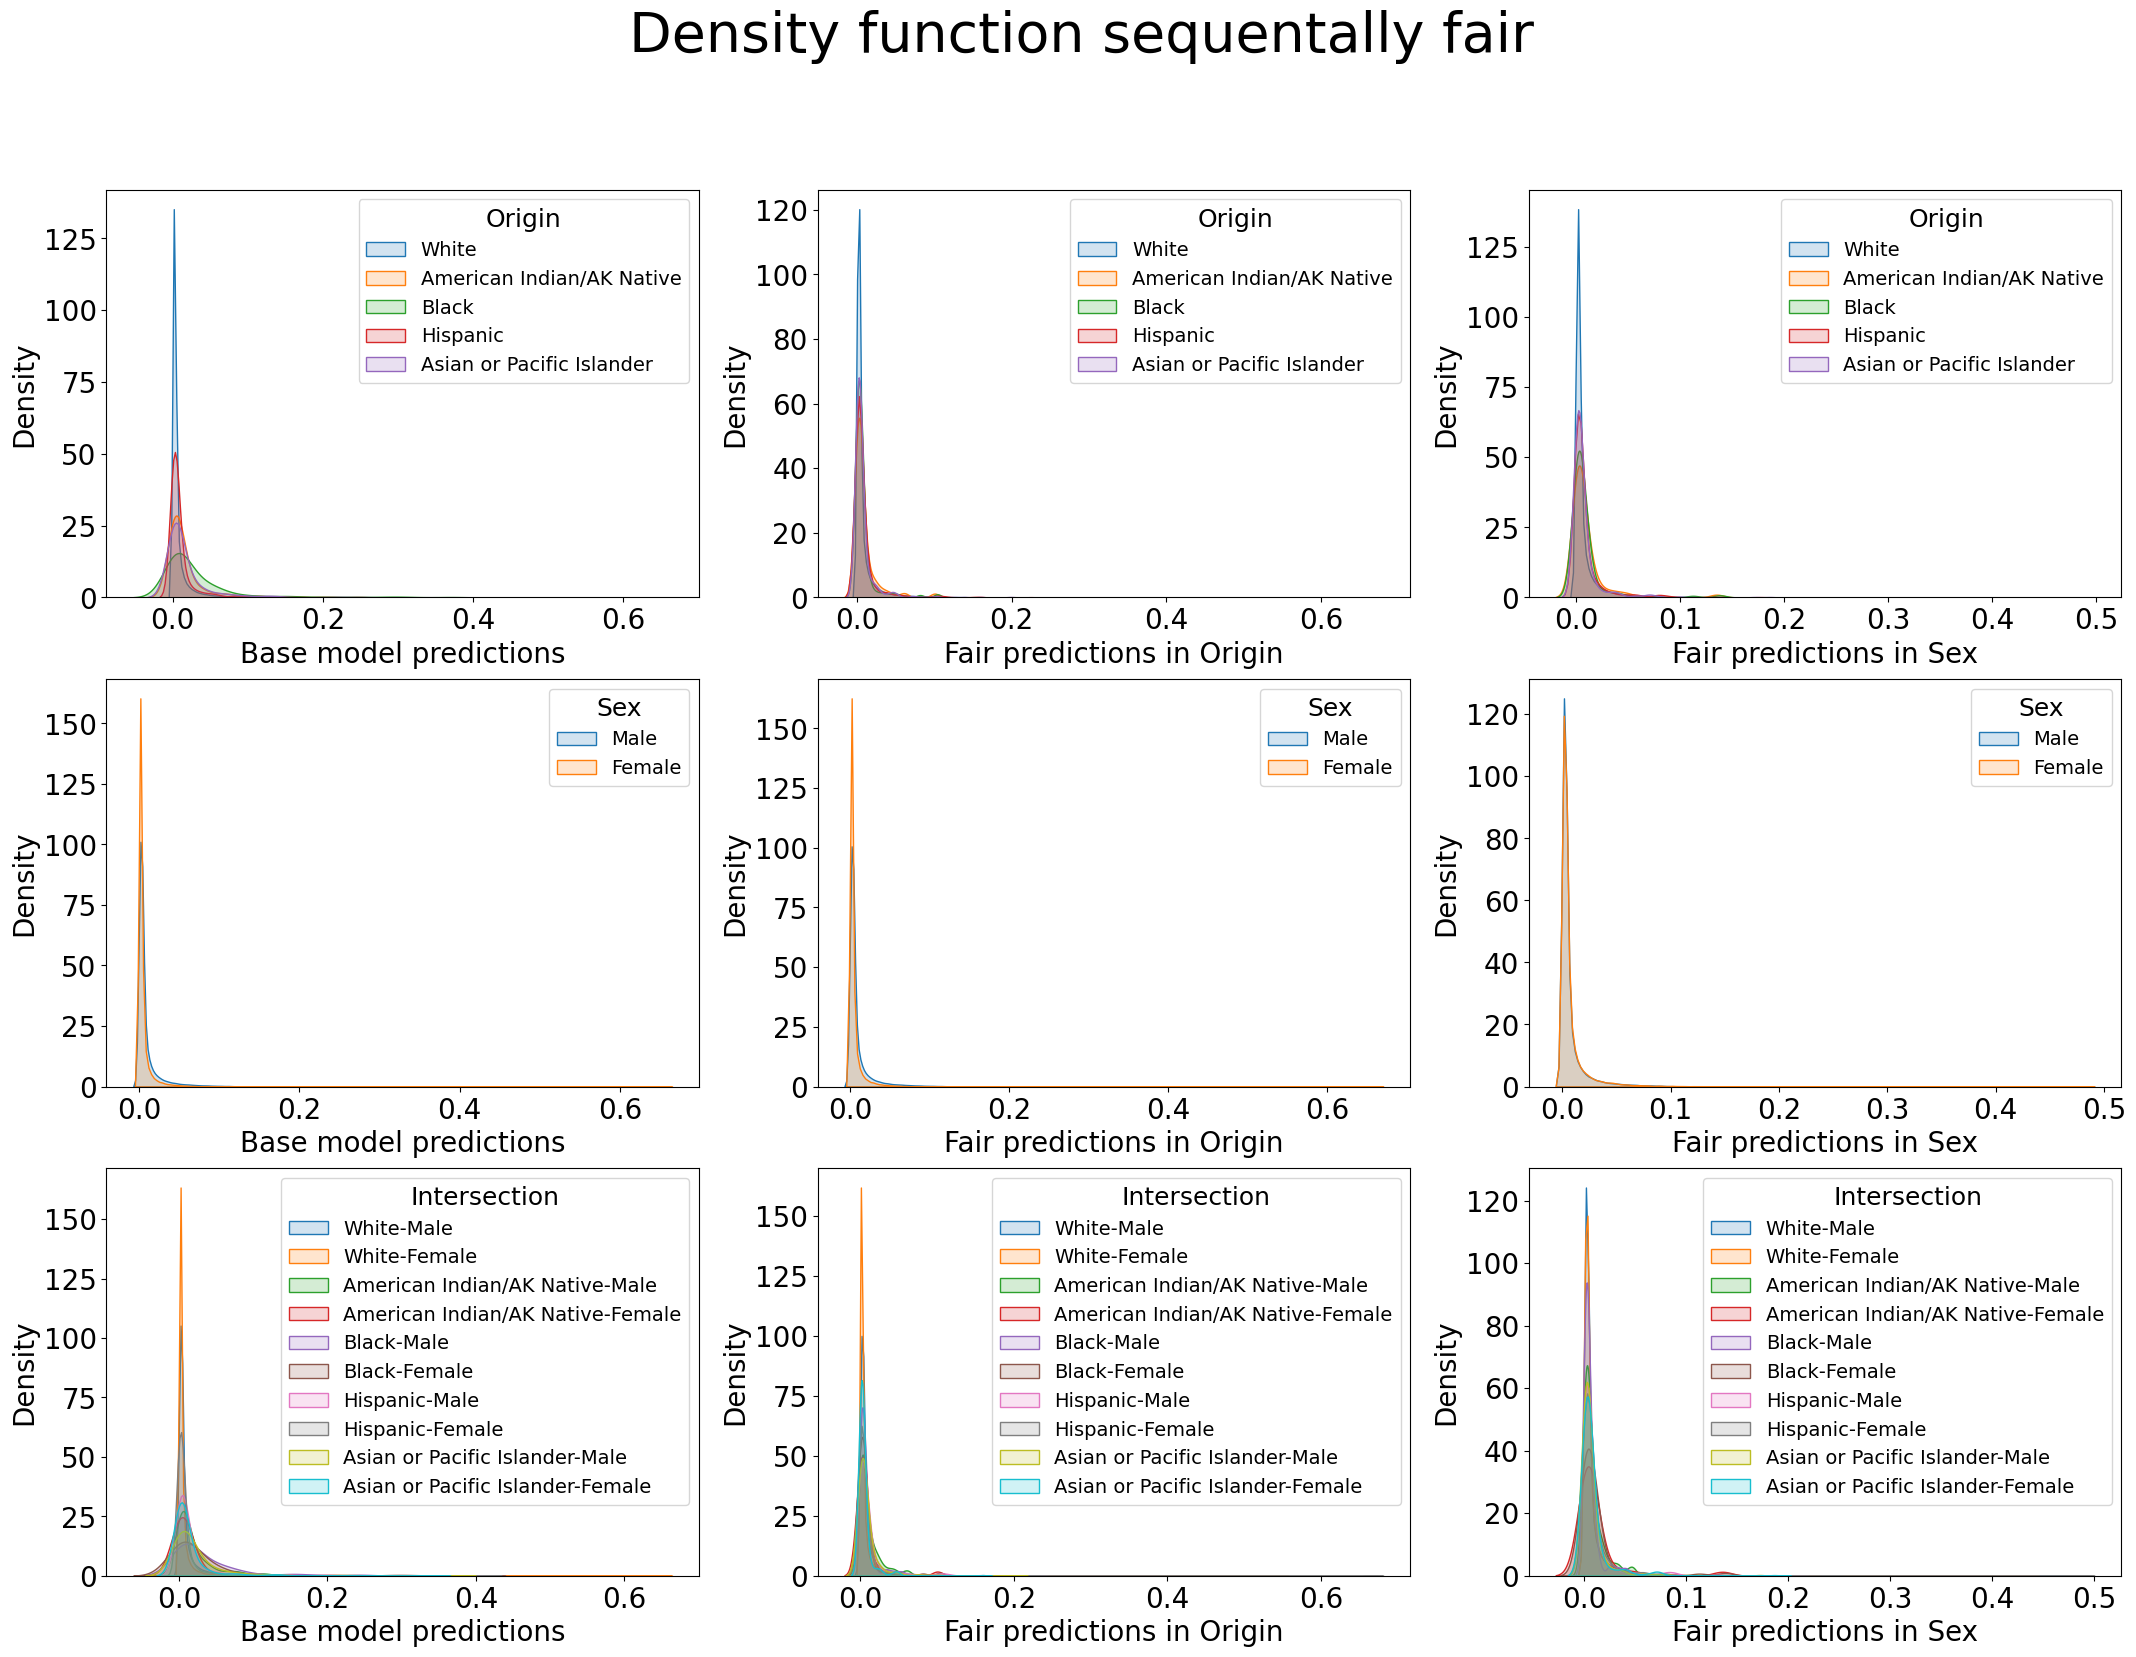

In [27]:
fair_density_plot(x_ssa_calib, x_ssa_test, scores_calib, scores_test)
plt.savefig("outputs/densities.pdf")

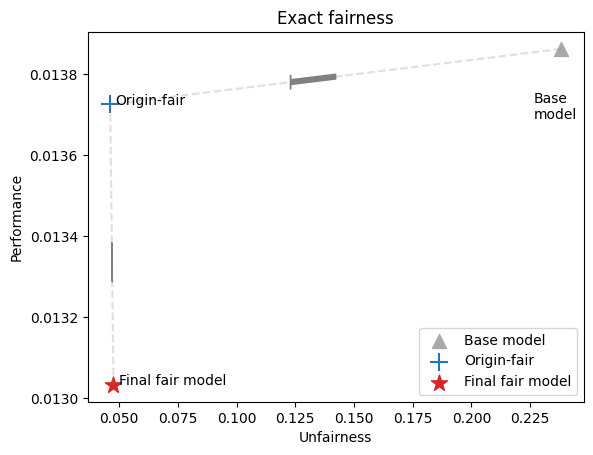

In [31]:
fair_arrow_plot(x_ssa_calib, x_ssa_test, scores_calib, scores_test, y_true_test, threshold=best_threshold)
plt.savefig("outputs/arrow_plot.pdf")

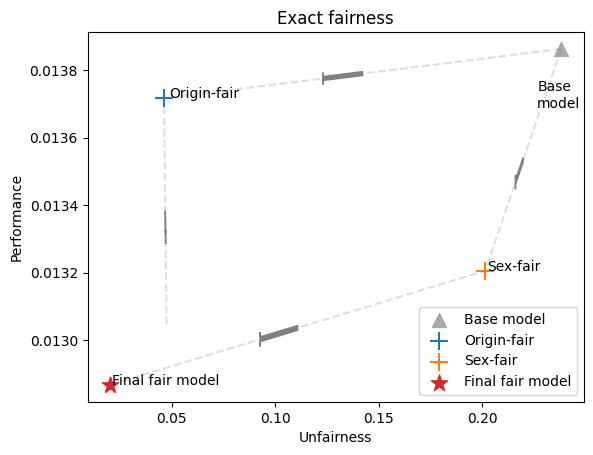

In [32]:
fair_multiple_arrow_plot(x_ssa_calib, x_ssa_test, scores_calib, scores_test, y_true_test, threshold=best_threshold)
plt.savefig("outputs/multiple_arrow_plot.pdf")

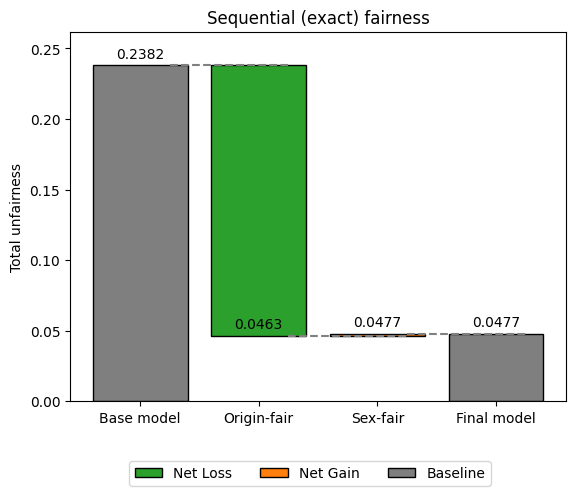

<Figure size 640x480 with 0 Axes>

In [33]:
fair_waterfall_plot(x_ssa_calib, x_ssa_test, scores_calib, scores_test)
plt.savefig("outputs/waterfall_plot.pdf")

# Approximate fairness

In [34]:
# Create instance of Wasserstein class (MSA)
approx_wst = MultiWasserstein()
approx_wst.fit(scores_calib, x_ssa_calib)
y_final_fair = approx_wst.transform(scores_test, x_ssa_test, epsilon=[0,0.5])
print("New array of approximately-fair predictions: ", y_final_fair) # returns the y_fair

New array of approximately-fair predictions:  [0.00200914 0.00159551 0.00100981 ... 0.00270822 0.00202375 0.00272191]


In [35]:
# We can calculate fairness of the y_final_fair and on the initial scores_test
print(f"Unfairness before mitigation: {unfairness(scores_test, x_ssa_test):.4f}")
print(f"Unfairness after mitigating biases from origin and sex: {unfairness(y_final_fair, x_ssa_test):.4f}")

Unfairness before mitigation: 0.2382
Unfairness after mitigating biases from origin and sex: 0.0421


In [36]:
# We can do the same with metrics : on the final fair y
# We first need to transform scores predicted into 0/1 values
print(f"Accuracy before mitigation: {performance(y_true_test, y_pred_test, accuracy_score):.4f}")
print(f"F1-score before mitigation: {performance(y_true_test, y_pred_test, f1_score):.4f}")
# Transform y_final_fair into class vector (0/1)
# Convert scores to binary class predictions
class_final_fair = (y_final_fair > threshold).astype(int)
print(f"Accuracy after mitigating biases from origin and gender: {performance(y_true_test, class_final_fair, accuracy_score):.4f}")
print(f"F1-score after mitigating biases from origin and gender: {performance(y_true_test, class_final_fair, f1_score):.4f}")

Accuracy before mitigation: 0.9861
F1-score before mitigation: 0.1364
Accuracy after mitigating biases from origin and gender: 0.9869
F1-score after mitigating biases from origin and gender: 0.1295


In [37]:
# To have all the steps of sequential fairness, we can take the dictionnary
# Dictionnary of sequential fair outputs if multiple sensitive attributes
y_seq_fair = approx_wst.y_fair
print("Steps in transformation of predictions: ", y_seq_fair)

Steps in transformation of predictions:  {'Base model': array([0.00222084, 0.00122892, 0.00120611, ..., 0.00205866, 0.0022453 ,
       0.00307263]), 'Origin': array([0.00222469, 0.00130073, 0.0011511 , ..., 0.0021757 , 0.00228309,
       0.00309907]), 'Sex': array([0.00200914, 0.00159551, 0.00100981, ..., 0.00270822, 0.00202375,
       0.00272191])}


In [38]:
# Calculate sequential unfairness
print(f"Unfairness before mitigation: {unfairness(y_seq_fair["Base model"], x_ssa_test):.4f}")
print(f"Unfairness after mitigating biases from origin: {unfairness(y_seq_fair["Origin"], x_ssa_test):.4f}")
print(f"Unfairness after mitigating biases from origin and gender: {unfairness(y_seq_fair["Sex"], x_ssa_test):.4f}")

Unfairness before mitigation: 0.2382
Unfairness after mitigating biases from origin: 0.0464
Unfairness after mitigating biases from origin and gender: 0.0421


In [39]:
# Calculate sequential unfairness in Origin only
print(f"Unfairness in Origin before mitigation: {unfairness(y_seq_fair["Base model"], x_ssa_test[['Origin']]):.4f}")
print(f"Unfairness in Origin after mitigating biases from origin: {unfairness(y_seq_fair["Origin"], x_ssa_test[['Origin']]):.4f}")
print(f"Unfairness in Origin after mitigating biases from origin and gender: {unfairness(y_seq_fair["Sex"], x_ssa_test[['Origin']]):.4f}")

Unfairness in Origin before mitigation: 0.2058
Unfairness in Origin after mitigating biases from origin: 0.0137
Unfairness in Origin after mitigating biases from origin and gender: 0.0274


In [40]:
# Calculate sequential unfairness in Gender only
print(f"Unfairness in Gender before mitigation: {unfairness(y_seq_fair["Base model"], x_ssa_test[['Sex']]):.4f}")
print(f"Unfairness in Gender after mitigating biases from origin: {unfairness(y_seq_fair["Origin"], x_ssa_test[['Sex']]):.4f}")
print(f"Unfairness in Gender after mitigating biases from origin and gender: {unfairness(y_seq_fair["Sex"], x_ssa_test[['Sex']]):.4f}")

Unfairness in Gender before mitigation: 0.0324
Unfairness in Gender after mitigating biases from origin: 0.0327
Unfairness in Gender after mitigating biases from origin and gender: 0.0147
